In [ ]:
pip install requests pandas tqdm matplotlib seaborn

In [ ]:
import os

# Set your Groq API key (store securely)
os.environ['GROQ_API_KEY'] = ""

In [ ]:
import pandas as pd

# Load GTD dataset (use local path or upload to Colab)
gtd = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1')

# Filter and clean
data = gtd[['eventid', 'summary']].dropna()
data['summary'] = data['summary'].str.strip().str.replace('\n', ' ')

/tmp/ipython-input-5-2069407316.py:4: DtypeWarning: Columns (4,31,33,60,62,76,79,94,96,114,121) have mixed types. Specify dtype option on import or set low_memory=False.
  gtd = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1')


In [ ]:
import requests

def call_groq_llm(prompt, model="llama3-8b-8192"):
    api_key = os.getenv("GROQ_API_KEY")
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": "You are an expert terrorism analyst."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.2
    }

    response = requests.post("https://api.groq.com/openai/v1/chat/completions", json=payload, headers=headers)

    if response.status_code == 200:
        return response.json()['choices'][0]['message']['content'].strip()
    else:
        print("Error:", response.text)
        return "unknown"

In [ ]:
import requests
import time

def call_groq_llm_safe(prompt, model="llama3-8b-8192", retries=3):
    api_key = os.getenv("GROQ_API_KEY")
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": "You are an expert terrorism analyst."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.2
    }

    for attempt in range(retries):
        response = requests.post("https://api.groq.com/openai/v1/chat/completions", json=payload, headers=headers)

        if response.status_code == 200:
            return response.json()['choices'][0]['message']['content'].strip()

        elif response.status_code == 429:
            try:
                wait_time = float(response.json()["error"]["message"].split("in ")[1].split("s")[0])
            except Exception:
                wait_time = 2
            print(f"⏳ Rate limit hit. Waiting {wait_time:.2f} seconds...")
            time.sleep(wait_time + 0.5)

        else:
            print(f"❌ Unexpected error: {response.status_code}\n{response.text}")
            return "unknown"

    return "unknown"

In [ ]:
def make_prompt(summary):
    return f"""Given the following description of a terrorist attack, identify the most likely motive behind the attack in one or two words.

Description: "{summary}"
Motive:"""

In [ ]:
# Step 0: Install required packages if needed
# pip install pandas requests matplotlib seaborn tqdm

import os
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

/tmp/ipython-input-3-3271348370.py:14: DtypeWarning: Columns (4,31,33,61,62,76,79,90,92,94,96,121) have mixed types. Specify dtype option on import or set low_memory=False.
  gtd = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1')


🔍 Predicting motives using Groq LLM...


Processing:  16%|█▌        | 8/50 [00:23<01:55,  2.75s/it]

❌ Error: 500
{"error":{"message":"Internal Server Error","type":"internal_server_error"}}



Processing: 100%|██████████| 50/50 [02:22<00:00,  2.84s/it]
/tmp/ipython-input-3-3271348370.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3-3271348370.py:119: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


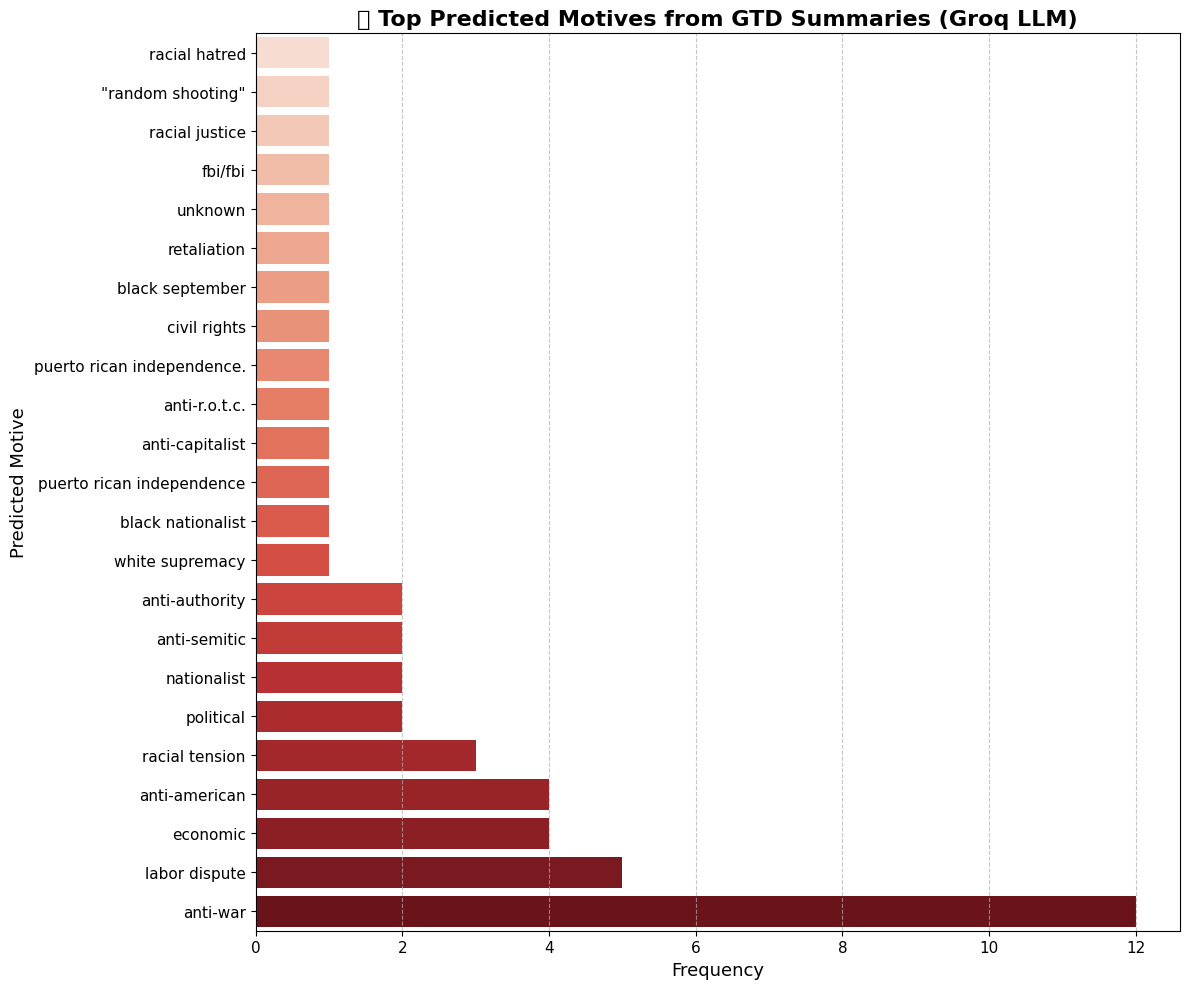

In [3]:

# Step 1: Set Groq API Key
os.environ['GROQ_API_KEY'] = ""

# Step 2: Load and preprocess GTD dataset
gtd = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1')
data = gtd[['eventid', 'summary']].dropna().copy()
data['summary'] = data['summary'].str.replace('\n', ' ').str.strip()

# Step 3: Prompt template
def make_prompt(summary):
    return f"""Given the following description of a terrorist attack, identify the most likely motive behind the attack in one or two words.\n\nDescription: "{summary}"\nMotive:"""

# Step 4: Call Groq LLM
def call_groq_llm_safe(prompt, model="llama3-8b-8192", retries=3):
    api_key = os.getenv("GROQ_API_KEY")
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": "You are an expert terrorism analyst."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.2
    }

    for attempt in range(retries):
        response = requests.post("https://api.groq.com/openai/v1/chat/completions", json=payload, headers=headers)
        if response.status_code == 200:
            return response.json()['choices'][0]['message']['content'].strip()
        elif response.status_code == 429:
            wait_time = 2
            print(f"⏳ Rate limit hit. Waiting {wait_time:.2f} seconds...")
            time.sleep(wait_time + 0.5)
        else:
            print(f"❌ Error: {response.status_code}\n{response.text}")
            return "unknown"
    return "unknown"

# Step 5: Predict Motives
batch_size = 50
subset = data.head(batch_size)
predictions = []

print("🔍 Predicting motives using Groq LLM...")
for summary in tqdm(subset['summary'], desc="Processing"):
    prompt = make_prompt(summary)
    motive = call_groq_llm_safe(prompt)
    predictions.append(motive)
    time.sleep(2.1)

# Step 6: Store Predictions
data.loc[subset.index, 'predicted_motive'] = predictions

# Step 7: Advanced Normalization using regex
def normalize_motive(motive):
    motive = motive.lower().strip()

    if re.search(r"\b(religion|islam|jihad|faith|holy)\b", motive):
        return 'religious'
    elif re.search(r"\b(anti[- ]?government|state|gov|dictator|regime)\b", motive):
        return 'anti-government'
    elif re.search(r"\b(politic|power|election|democracy|reform)\b", motive):
        return 'political'
    elif re.search(r"\b(ethnic|tribal|race|minority|ethno)\b", motive):
        return 'ethnic'
    elif re.search(r"\b(separat|independen|autonom|territor)\b", motive):
        return 'separatist'
    elif re.search(r"\b(retaliat|revenge|retribution|vengeance)\b", motive):
        return 'retaliation'
    elif re.search(r"\b(economic|financial|money|poverty)\b", motive):
        return 'economic'
    elif re.search(r"\b(crime|gang|drug|mafia|cartel)\b", motive):
        return 'criminal'
    elif re.search(r"\b(ideolog|doctrine|extremism)\b", motive):
        return 'ideological'
    elif re.search(r"\b(military|army|soldier|warfare|invasion)\b", motive):
        return 'military'
    elif re.search(r"\b(unknown|not known|no motive|unclear|unspecified)\b", motive):
        return 'unknown'
    return motive

# Clean and normalize
motive_series = data['predicted_motive'].dropna().astype(str)
motive_series = motive_series[motive_series.str.strip().str.lower() != 'nan']
motive_series = motive_series[motive_series.str.strip() != '']
data.loc[motive_series.index, 'normalized_motive'] = motive_series.apply(normalize_motive)

# Step 8: Better red gradient (skip very light colors)
motive_counts = data['normalized_motive'].value_counts().sort_values(ascending=True)
num_motives = len(motive_counts)

# Skip very pale colors by slicing into the darker reds
base_colors = sns.color_palette("Reds", n_colors=num_motives + 3)[3:]

plt.figure(figsize=(12, 10))
sns.barplot(
    x=motive_counts.values,
    y=motive_counts.index,
    palette=base_colors
)
plt.title('🔥 Top Predicted Motives from GTD Summaries (Groq LLM)', fontsize=16, weight='bold')
plt.xlabel('Frequency', fontsize=13)
plt.ylabel('Predicted Motive', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
